# PREDICTION DE LA PERFORMANCE DES EMPLOYES 

AUTEURS : MERAOUI Camélia, PERVENCHE Clémence, ROCHER Ludovic

## Import 

In [79]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import KFold, cross_validate
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score


## Fonctions utiles

### Exécution des classifiers avec cross-validate

In [80]:


def run_classifiers(clfs, X, Y):
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    for i, clf in clfs.items():
        scoring_metrics = {'accuracy': make_scorer(accuracy_score),
                           'precision': make_scorer(precision_score, average='weighted'),
                           'recall': make_scorer(recall_score, average='weighted'),
                           'f1_score': make_scorer(f1_score, average='weighted')}
        cv_results = cross_validate(clf, X, Y, cv=kf, scoring=scoring_metrics)
        
        print("Temps d'exécution de l'algorithme pour l'apprentissage de {0} : {1:.2f} secondes".format(i, np.mean(cv_results["fit_time"])))
        print("Temps d'exécution de l'algorithme pour la prédiction de {0} : {1:.2f} secondes".format(i, np.mean(cv_results["score_time"])))
        print("Accuracy for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_results['test_accuracy']), np.std(cv_results['test_accuracy'])))
        print("Precision for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_results['test_precision']), np.std(cv_results['test_precision'])))
        print("Recall for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_results['test_recall']), np.std(cv_results['test_recall'])))
        print("F1 Score for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_results['test_f1_score']), np.std(cv_results['test_f1_score'])))
        print("\n")



### Extraire l'année des dates

In [81]:
def extract_year(date_string):
    if date_string != "?" and date_string is not np.nan:
        return int(str(date_string).split("-")[-1])
    return -1

### Pipeline

In [82]:
def create_pipeline(steps, X_, y_, pipeline_file):
    pipeline = Pipeline(steps)
    pipeline.fit(X_, y_)
    with open(pipeline_file+'.pkl', 'wb') as file:
        pickle.dump(pipeline, file)

def load_and_predict(X_test_, pipeline_file):
    with open(pipeline_file+'.pkl', 'rb') as file:
        loaded_pipeline = pickle.load(file)
    predictions = loaded_pipeline.predict(X_test_)

    return predictions

## File paths

In [83]:
file_path = "../data/productivity_employees_green/"

employees_data_perf_path = f"{file_path}employee_data_performances.csv"
employee_engagement_survey_data_path = f"{file_path}employee_engagement_survey_data.csv"
recruitment_data = f"{file_path}recruitment_data.csv"
training_and_development_data = f"{file_path}training_and_development_data.csv"

## Ouvrir le fichier et visualisation

### Ouvrir le fichier en format dataframe

In [84]:
df_emp_perf = pd.read_csv(employees_data_perf_path, sep=',')

### Récupérer les années à partir des dates

In [85]:
df_emp_perf['DOB'] = df_emp_perf['DOB'].apply(extract_year)
df_emp_perf['StartDate'] = df_emp_perf['StartDate'].apply(extract_year)

### Affichage du nombre de valeurs uniques pour chaque colonnes

In [86]:
for col in df_emp_perf:
    print(f'Column name: ', col , '\nuniques val: ', df_emp_perf[col].nunique(), '\n------------')

Column name:  EmpID 
uniques val:  3000 
------------
Column name:  FirstName 
uniques val:  1597 
------------
Column name:  LastName 
uniques val:  1137 
------------
Column name:  StartDate 
uniques val:  6 
------------
Column name:  ExitDate 
uniques val:  820 
------------
Column name:  Title 
uniques val:  32 
------------
Column name:  Supervisor 
uniques val:  2952 
------------
Column name:  ADEmail 
uniques val:  2998 
------------
Column name:  BusinessUnit 
uniques val:  10 
------------
Column name:  EmployeeStatus 
uniques val:  5 
------------
Column name:  EmployeeType 
uniques val:  3 
------------
Column name:  PayZone 
uniques val:  3 
------------
Column name:  EmployeeClassificationType 
uniques val:  3 
------------
Column name:  TerminationType 
uniques val:  5 
------------
Column name:  TerminationDescription 
uniques val:  1533 
------------
Column name:  DepartmentType 
uniques val:  6 
------------
Column name:  Division 
uniques val:  25 
------------
Colu

### Suppression des colonnes inutiles

In [87]:
columns_to_drop = ['EmpID', 'FirstName', 'LastName', 'ExitDate', 'Supervisor', 'ADEmail', 'TerminationDescription', 'LocationCode' ]
df_emp_perf = df_emp_perf.drop(columns_to_drop, axis=1)
df_emp_perf.head()

,StartDate,Title,BusinessUnit,EmployeeStatus,EmployeeType,PayZone,EmployeeClassificationType,TerminationType,DepartmentType,Division,DOB,State,JobFunctionDescription,GenderCode,RaceDesc,MaritalDesc,Performance Score,Current Employee Rating
0,19,Production Technician I,CCDR,Active,Contract,Zone C,Temporary,Unk,Production,Finance & Accounting,1969,MA,Accounting,Female,White,Widowed,Fully Meets,4
1,23,Production Technician I,EW,Active,Contract,Zone A,Part-Time,Unk,Production,Aerial,1965,MA,Labor,Male,Hispanic,Widowed,Fully Meets,3
2,18,Area Sales Manager,PL,Active,Full-Time,Zone B,Part-Time,Unk,Sales,General - Sga,1991,MA,Assistant,Male,Hispanic,Widowed,Fully Meets,4
3,21,Area Sales Manager,CCDR,Active,Contract,Zone A,Full-Time,Unk,Sales,Finance & Accounting,1998,ND,Clerk,Male,Other,Single,Fully Meets,2
4,19,Area Sales Manager,TNS,Active,Contract,Zone A,Temporary,Unk,Sales,General - Con,1969,FL,Laborer,Female,Other,Married,Fully Meets,3


In [88]:
for col in df_emp_perf:
    print(f'Column name: ', col , '\nuniques val: ', df_emp_perf[col].nunique(), '\n------------')

Column name:  StartDate 
uniques val:  6 
------------
Column name:  Title 
uniques val:  32 
------------
Column name:  BusinessUnit 
uniques val:  10 
------------
Column name:  EmployeeStatus 
uniques val:  5 
------------
Column name:  EmployeeType 
uniques val:  3 
------------
Column name:  PayZone 
uniques val:  3 
------------
Column name:  EmployeeClassificationType 
uniques val:  3 
------------
Column name:  TerminationType 
uniques val:  5 
------------
Column name:  DepartmentType 
uniques val:  6 
------------
Column name:  Division 
uniques val:  25 
------------
Column name:  DOB 
uniques val:  61 
------------
Column name:  State 
uniques val:  28 
------------
Column name:  JobFunctionDescription 
uniques val:  83 
------------
Column name:  GenderCode 
uniques val:  2 
------------
Column name:  RaceDesc 
uniques val:  5 
------------
Column name:  MaritalDesc 
uniques val:  4 
------------
Column name:  Performance Score 
uniques val:  4 
------------
Column name:  

### Numérisation des colonnes

#### Utilisation de OneHotEncoder

In [89]:

cols = ['EmployeeStatus', 'EmployeeType', 'PayZone', 'EmployeeClassificationType', 'TerminationType', 'GenderCode', 'RaceDesc', 'MaritalDesc', 'Performance Score']

encoder = OneHotEncoder()

X = df_emp_perf.iloc[:, :-1]

non_encoded_cols = []

for column in cols:
    if X[column].dtype == 'object':
        encoder.fit(df_emp_perf[[column]])
        encoded_data = encoder.transform(df_emp_perf[[column]]).toarray()
        X_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())
        X = pd.concat([X.drop(column, axis=1), X_encoded], axis=1)
    else:
        non_encoded_cols.append(column)

X = pd.concat([X, df_emp_perf[non_encoded_cols]], axis=1)




In [90]:
X.head()

,StartDate,Title,BusinessUnit,DepartmentType,Division,DOB,State,JobFunctionDescription,EmployeeStatus_Active,EmployeeStatus_Future Start,...,RaceDesc_Other,RaceDesc_White,MaritalDesc_Divorced,MaritalDesc_Married,MaritalDesc_Single,MaritalDesc_Widowed,Performance Score_Exceeds,Performance Score_Fully Meets,Performance Score_Needs Improvement,Performance Score_PIP
0,19,Production Technician I,CCDR,Production,Finance & Accounting,1969,MA,Accounting,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,23,Production Technician I,EW,Production,Aerial,1965,MA,Labor,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,18,Area Sales Manager,PL,Sales,General - Sga,1991,MA,Assistant,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,21,Area Sales Manager,CCDR,Sales,Finance & Accounting,1998,ND,Clerk,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,19,Area Sales Manager,TNS,Sales,General - Con,1969,FL,Laborer,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Pour chaque colonne, on va récupérer la moyenne de chaque feature qui va correspondre à la valeur de cette colonne

In [91]:
cols_to_iterate = ['Title', 'BusinessUnit', 'DepartmentType', 'Division', 'State', 'JobFunctionDescription'  ]

for column in cols_to_iterate:
    freqs = X[column].value_counts(normalize=True)
    X[column] = X[column].map(freqs)


In [92]:
X.head()

,StartDate,Title,BusinessUnit,DepartmentType,Division,DOB,State,JobFunctionDescription,EmployeeStatus_Active,EmployeeStatus_Future Start,...,RaceDesc_Other,RaceDesc_White,MaritalDesc_Divorced,MaritalDesc_Married,MaritalDesc_Single,MaritalDesc_Widowed,Performance Score_Exceeds,Performance Score_Fully Meets,Performance Score_Needs Improvement,Performance Score_PIP
0,19,0.440333,0.100000,0.673333,0.023333,1969,0.883667,0.003000,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,23,0.440333,0.100667,0.673333,0.065333,1965,0.883667,0.002000,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,18,0.099000,0.100333,0.110333,0.039000,1991,0.883667,0.008000,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,21,0.099000,0.100000,0.110333,0.023333,1998,0.001333,0.012333,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,19,0.099000,0.099000,0.110333,0.169667,1969,0.000333,0.174000,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [93]:
X.describe()

,StartDate,Title,BusinessUnit,DepartmentType,Division,DOB,State,JobFunctionDescription,EmployeeStatus_Active,EmployeeStatus_Future Start,...,RaceDesc_Other,RaceDesc_White,MaritalDesc_Divorced,MaritalDesc_Married,MaritalDesc_Single,MaritalDesc_Widowed,Performance Score_Exceeds,Performance Score_Fully Meets,Performance Score_Needs Improvement,Performance Score_PIP
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,20.579000,0.239522,0.100012,0.488340,0.124572,1971.193000,0.781911,0.075770,0.819333,0.023000,...,0.194000,0.199667,0.247000,0.254667,0.257333,0.241000,0.123000,0.787000,0.059000,0.031000
std,1.495495,0.185172,0.001093,0.266806,0.096068,17.692449,0.280499,0.059934,0.384806,0.149928,...,0.395495,0.399816,0.431339,0.435746,0.437237,0.427762,0.328492,0.409496,0.235664,0.173347
min,18.000000,0.001667,0.098000,0.008000,0.000667,1941.000000,0.000333,0.000333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.051333,0.099000,0.143333,0.036667,1956.000000,0.883667,0.018667,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,21.000000,0.172000,0.100333,0.673333,0.091667,1971.500000,0.883667,0.056333,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,22.000000,0.440333,0.101000,0.673333,0.263000,1987.000000,0.883667,0.122667,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,23.000000,0.440333,0.101333,0.673333,0.263000,2001.000000,0.883667,0.174000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Transformation d'un problème de régression en problème de classification 

On considère que les performances en dessous de 4 sont mauvaises

In [94]:
X_ = X.values

y = df_emp_perf.iloc[:, -1].astype(int)
y = np.where(y <= 3, 0, 1)


### Dimensions de X et y

In [95]:
print(X_.shape)
print(y.shape)

(3000, 42)
(3000,)


### Affichage de pourcentages d'occurence

In [96]:
unique_labels, counts = np.unique(y, return_counts=True)

percentages = counts / len(y) * 100

for label, percentage in zip(unique_labels, percentages):
    print(f"Label {label}: {percentage:.2f}%")

Label 0: 77.03%
Label 1: 22.97%


## Apprentissage supervisé

### Classifieur

In [97]:
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

clfs = {
   'XGBOOST': GradientBoostingClassifier(n_estimators=200),
   'RF200': RandomForestClassifier(n_estimators=200, random_state=1),
   'MLP1':MLPClassifier(hidden_layer_sizes=(40, 20)),
   'KNN5': KNeighborsClassifier(n_neighbors=15),
   'BAGGING':BaggingClassifier(DecisionTreeClassifier(), n_estimators=200),
   'ADABOOST': AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=200),
}

### Utilisation de cross-validate

In [98]:
X_norm = MinMaxScaler().fit_transform(X_)
run_classifiers(clfs, X_norm, y.astype(int))

Temps d'exécution de l'algorithme pour l'apprentissage de XGBOOST : 0.84 secondes
Temps d'exécution de l'algorithme pour la prédiction de XGBOOST : 0.01 secondes
Accuracy for XGBOOST is: 0.759 +/- 0.036
Precision for XGBOOST is: 0.689 +/- 0.047
Recall for XGBOOST is: 0.759 +/- 0.036
F1 Score for XGBOOST is: 0.692 +/- 0.048


Temps d'exécution de l'algorithme pour l'apprentissage de RF200 : 0.67 secondes
Temps d'exécution de l'algorithme pour la prédiction de RF200 : 0.02 secondes
Accuracy for RF200 is: 0.767 +/- 0.036
Precision for RF200 is: 0.709 +/- 0.083
Recall for RF200 is: 0.767 +/- 0.036
F1 Score for RF200 is: 0.677 +/- 0.046


Temps d'exécution de l'algorithme pour l'apprentissage de MLP1 : 3.28 secondes
Temps d'exécution de l'algorithme pour la prédiction de MLP1 : 0.00 secondes
Accuracy for MLP1 is: 0.681 +/- 0.023
Precision for MLP1 is: 0.659 +/- 0.031
Recall for MLP1 is: 0.681 +/- 0.023
F1 Score for MLP1 is: 0.667 +/- 0.031


Temps d'exécution de l'algorithme pour l'apprenti

In [99]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_)
run_classifiers(clfs, X_pca, y.astype(int))

Temps d'exécution de l'algorithme pour l'apprentissage de XGBOOST : 1.07 secondes
Temps d'exécution de l'algorithme pour la prédiction de XGBOOST : 0.01 secondes
Accuracy for XGBOOST is: 0.753 +/- 0.030
Precision for XGBOOST is: 0.639 +/- 0.035
Recall for XGBOOST is: 0.753 +/- 0.030
F1 Score for XGBOOST is: 0.671 +/- 0.045


Temps d'exécution de l'algorithme pour l'apprentissage de RF200 : 1.34 secondes
Temps d'exécution de l'algorithme pour la prédiction de RF200 : 0.02 secondes
Accuracy for RF200 is: 0.756 +/- 0.033
Precision for RF200 is: 0.647 +/- 0.049
Recall for RF200 is: 0.756 +/- 0.033
F1 Score for RF200 is: 0.672 +/- 0.045


Temps d'exécution de l'algorithme pour l'apprentissage de MLP1 : 0.39 secondes
Temps d'exécution de l'algorithme pour la prédiction de MLP1 : 0.00 secondes
Accuracy for MLP1 is: 0.770 +/- 0.035
Precision for MLP1 is: 0.595 +/- 0.052
Recall for MLP1 is: 0.770 +/- 0.035
F1 Score for MLP1 is: 0.671 +/- 0.046


Temps d'exécution de l'algorithme pour l'apprenti

In [100]:
best_data = MinMaxScaler().fit_transform(X_)
best_label = y.astype(int)
best_model = RandomForestClassifier()

## Importance des variables

In [101]:
def trace_hist_importance(dataframe, best_data_, y_):
    # RandomForestClassifier qui va estimer l'importance de chaque variable
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(best_data_, y_)

    importances=clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
    sorted_idx = np.argsort(importances)[::-1]
    features = dataframe.columns

    padding = np.arange(best_data_.size/len(best_data_)) + 0.5
    plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center')
    plt.yticks(padding, features[sorted_idx])
    plt.xlabel("Relative Importance")
    plt.title("Variable Importance")
    plt.show()

    return sorted_idx

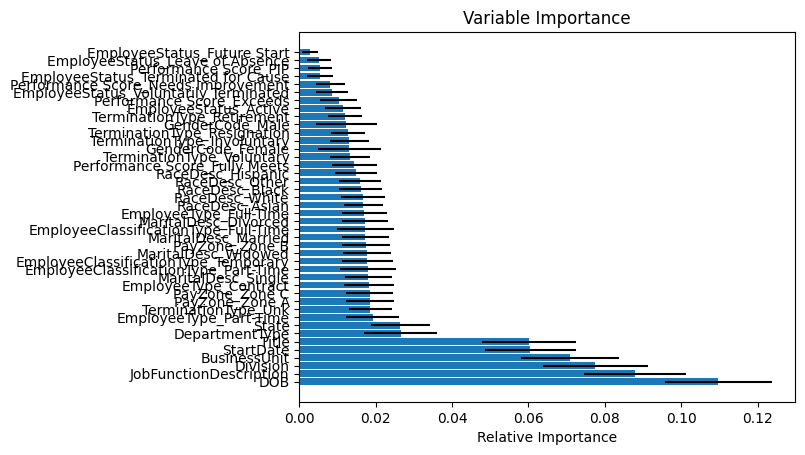

In [102]:
sorted_idx = trace_hist_importance(X, best_data, y)

## Trouver le nombre de variables

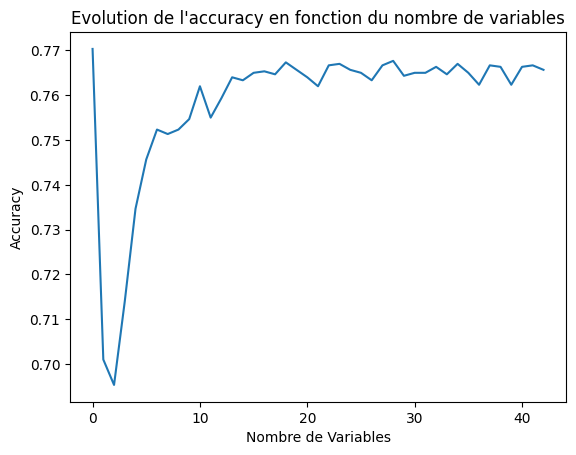

In [103]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)

best_model = RandomForestClassifier(n_estimators=200)

scores = np.zeros(best_data.shape[1] + 1)

for f in range(best_data.shape[1] + 1):
    X1_f = best_data[:, sorted_idx[:f + 1]]
    
    res = cross_validate(best_model, X1_f, best_label, cv=kf, scoring='accuracy')
    
    scores[f] = np.mean(res['test_score'])

plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Accuracy")
plt.title("Evolution de l'accuracy en fonction du nombre de variables")
plt.show()

## Recherche des meilleurs paramètres

In [104]:
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'min_samples_split': [None, 2, 10],
    'min_samples_leaf': [None, 1, 4]
}

grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(best_data, best_label)
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score de validation croisée:", grid_search.best_score_)
best_model = grid_search.best_estimator_

Meilleurs paramètres: {'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Meilleur score de validation croisée: 0.7526666666666667


## Pipeline

In [105]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.freqs = {}

    def fit(self, X_, y=None):
        for column in X_.columns:
            self.freqs[column] = X_[column].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in X.columns:
            X_copy[column] = X[column].map(self.freqs[column])
        return X_copy

In [106]:
cols = ['EmployeeStatus', 'EmployeeType', 'PayZone', 'EmployeeClassificationType', 'TerminationType', 'GenderCode', 'RaceDesc', 'MaritalDesc', 'Performance Score']
cols_to_iterate = ['Title', 'BusinessUnit', 'DepartmentType', 'Division', 'State', 'JobFunctionDescription']
encoder = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', encoder, cols),
        ('freq_encode', FrequencyEncoder(), cols_to_iterate)
    ],
    remainder='drop'

)
steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')), 
    ('normalisation', MinMaxScaler()),  
    ('classifier', best_model)  
]


df_emp_perf_test = pd.read_csv(employees_data_perf_path, sep=',')
X_train = df_emp_perf_test.iloc[:,:-1]
y_train = y
create_pipeline(steps, X_train, y_train, "../artifacts/predict_green_performance_pipeline_nb")


In [107]:
X_test = df_emp_perf_test.iloc[0,:-1]
print(X_test.shape)

(25,)


In [108]:
X_test = df_emp_perf_test.iloc[:,:-1]
y_test = y

predictions = load_and_predict(X_test, "../artifacts/predict_green_performance_pipeline_nb")

accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.7956666666666666
